Fix potential bugs in formulation of edge Neural ODE, i.e. when doing the forward pass over the `ODEFunc`, ensure we return zeros for the latent dimension block of the vector, so it does not calculate gradients over those, try learning with only the ICs

In [118]:
run_tc1 = False
run_tc2 = False

In [2]:
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
adjoint=True

In [5]:
!pip install --user -q torchdiffeq

In [6]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
# # Generative model for noisy data based on ODE
# parser = argparse.ArgumentParser('PNODE')
# parser.add_argument('--test-mode', 
#                     type=str, 
#                     default='test-case-1', 
#                     help="Test mode: single-self-interp MSE obj",
#                     options=['test-case'])



# args = parser.parse_args(args=())

In [9]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

In [10]:
import re
import os
import time

In [11]:
%matplotlib inline

In [12]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [13]:
import edge_utils as edut

In [14]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [15]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [16]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [17]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [18]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [19]:
rd_2161 = getRValuesAllSims(ed_2161)

In [20]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [21]:
import edge_utils as edut

In [22]:
# we are removing some data where the edge detection is not necessarily super reliable.
sims_to_remove = np.array([33, 39, 63, 73, 113, 128, 131, 142, 193, 218, 253, 264, 273, 312, 313, 324])

In [23]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [24]:
theta_s_2161, theta_e_2161 = np.linspace(0, 360, 512)[160] + 1.2 * 180 - 360, np.linspace(0, 360, 512)[320] + 1.2 * 180 - 360
print("Range of angles for CR2161: {} {}".format(theta_s_2161, theta_e_2161))

Range of angles for CR2161: -31.279843444227026 81.44031311154595


In [25]:
nTimes, nTheta_2161, nSims_2161 = ed_2161.shape
nTimes, nTheta_2161, nSims_2161

(90, 160, 278)

In [26]:
theta_grid = np.linspace(np.ceil(theta_s_2161), np.ceil(theta_e_2161), nTheta_2161)

In [27]:
sd_modified = np.setdiff1d(sd_2161, sims_to_remove)

In [28]:
len(sd_modified)

262

In [29]:
# extract training and test sets. for now just random.

from numpy.random import Generator, PCG64
rng = Generator(PCG64())

nTrain = int(np.floor(0.8 * len(sd_modified)))
nTest = len(sd_modified) - nTrain

nTrain, nTest

(209, 53)

In [30]:
sd_train = np.sort(np.random.choice(sd_modified, nTrain, replace=False))
sd_test = np.setdiff1d(sd_modified, sd_train)
sd_test

array([ 34,  37,  40,  42,  47,  48,  49,  51,  53,  71,  77,  79,  80,
        82,  86,  90,  94,  95, 107, 121, 123, 135, 140, 148, 151, 152,
       155, 161, 181, 185, 192, 202, 208, 212, 213, 214, 219, 224, 227,
       238, 239, 243, 255, 263, 267, 271, 278, 279, 298, 306, 314, 322,
       325])

In [31]:
sd_test.shape

(53,)

In [32]:
def getRValuesAllSims(edge_data_matrix):
    """
    Return r values for all sims at once so we don't lose time in training processing r values repeatedly
    """
    r_data_matrix = np.zeros(edge_data_matrix.shape)
    nsims = edge_data_matrix.shape[2]
    for i in range(nsims):
        r_vals, theta_vals = edut.getRValues(edge_data_matrix, simIdx=i, minStartIdx=0)
        r_data_matrix[:, :, i] = r_vals

    return r_data_matrix

In [33]:
rd_2161 = getRValuesAllSims(ed_2161)

### Set up for Parametrized and Regular Neural ODEs

In [34]:
# get the param list for CR2161, get background values as well

In [35]:
cme_params = pd.read_csv("./restarts_CR2161.csv")
cme_params.head()

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4


In [36]:
bg_params = pd.read_csv("./backgrounds_CR2161.csv")
bg_params

,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5987,547686.9,259077.5
1,0.6876,514248.2,170240.5
2,0.7334,437169.7,242477.4
3,0.8010,378833.7,147856.5
4,0.9431,491082.5,205150.8
5,1.0077,349735.7,230084.9
6,1.0404,668772.0,278163.0
7,1.0921,463650.6,299730.0
8,1.2009,337215.4,113682.7
9,1.2292,583776.3,160912.2


In [37]:
unique_bg = cme_params.restartdir.unique()
unique_bg

array([ 4, 12])

In [38]:
bg_params.FactorB0[3]

0.801

In [39]:
bg_params.shape

(30, 3)

In [40]:
# identify which rows correspond to a particular background
cme_param_bg_idx = []
for bg in unique_bg:
    cme_param_bg_idx.append(np.array((cme_params.restartdir == bg).to_list()))

# now append columns to cme_params dataframe to merge

In [41]:
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,restartdir,realization
0,0.58375,22.526622,0.682075,204.725,1,4,4
1,0.52625,6.919483,0.519179,164.225,1,4,4
2,0.72625,5.087500,0.662022,233.975,1,4,4
3,0.36125,18.360770,0.420743,200.675,-1,4,4
4,0.69125,8.127120,0.735101,184.925,1,4,4
...,...,...,...,...,...,...,...
295,0.36250,32.665259,0.436133,197.750,-1,12,5
296,0.46250,26.757500,0.443711,224.750,1,12,5
297,0.76250,16.930533,0.874492,215.750,-1,12,5
298,0.61250,21.948929,0.553164,188.750,1,12,5


In [42]:
bg_params_to_insert = np.zeros((cme_params.shape[0], bg_params.shape[1]))
for bg_idx, bg in enumerate(unique_bg):
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 0] = bg_params.FactorB0[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 1] = bg_params.PoyntingFluxPerBSi[bg - 1]
    bg_params_to_insert[cme_param_bg_idx[bg_idx], 2] = bg_params.LperpTimesSqrtBSi[bg - 1]

cme_params["FactorB0"] = pd.Series(bg_params_to_insert[:, 0])
cme_params["PoyntingFluxPerBSi"] = pd.Series(bg_params_to_insert[:, 1])
cme_params["LperpTimesSqrtBSi"] = pd.Series(bg_params_to_insert[:, 2])
cme_params["SimID"] = pd.Series(np.linspace(31, 330, 300))
sim_idx_successful = sd_2161 - 30 - 1
sim_idx_to_drop = np.setdiff1d(np.linspace(0, 299, 300), sim_idx_successful).astype(int).tolist()

sim_idx_to_drop
cme_params.drop(["restartdir"], axis=1, inplace=True)
cme_params.drop(sim_idx_to_drop, inplace=True)
cme_params.drop(["SimID"], axis=1, inplace=True)
cme_params

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.58375,22.526622,0.682075,204.725,1,4,0.8010,378833.7,147856.5
1,0.52625,6.919483,0.519179,164.225,1,4,0.8010,378833.7,147856.5
2,0.72625,5.087500,0.662022,233.975,1,4,0.8010,378833.7,147856.5
3,0.36125,18.360770,0.420743,200.675,-1,4,0.8010,378833.7,147856.5
4,0.69125,8.127120,0.735101,184.925,1,4,0.8010,378833.7,147856.5
...,...,...,...,...,...,...,...,...,...
294,0.73750,15.331483,0.721367,170.750,-1,5,1.3016,304514.4,283042.3
295,0.36250,32.665259,0.436133,197.750,-1,5,1.3016,304514.4,283042.3
296,0.46250,26.757500,0.443711,224.750,1,5,1.3016,304514.4,283042.3
297,0.76250,16.930533,0.874492,215.750,-1,5,1.3016,304514.4,283042.3


In [43]:
cme_params.ApexHeight.min(), cme_params.ApexHeight.max()

(0.280873828, 0.928935547)

In [44]:
0.875 * 0.3, 1.25 * 0.8

(0.2625, 1.0)

In [45]:
cme_params.BStrength.min(), cme_params.BStrength.max()

(5.0875, 42.76293137)

In [46]:
(0.5 / 0.8) * 19.25 * 0.37, (2.0 / 0.3) * 19.25 * 0.37

(4.4515625, 47.483333333333334)

In [47]:
cme_params.OrientationCme.min(), cme_params.OrientationCme.max()

(155.225, 244.775)

In [48]:
200 - 45, 200 + 45

(155, 245)

In [49]:
type(cme_params.min())
# cme_params.max()

pandas.core.series.Series

In [50]:
cme_p_min = cme_params.min()
cme_p_min.BStrength = 4.4516
cme_p_min.Radius = 0.3
cme_p_min.OrientationCme = 155
cme_p_min.iHelicity = -1
cme_p_min.ApexHeight = 0.2625
cme_p_min.realization = 1
cme_p_min.FactorB0 = 0.54
cme_p_min.PoyntingFluxPerBSi = 0.3e6
cme_p_min.LperpTimesSqrtBSi = 0.3e5

cme_p_min

Radius                     0.3000
BStrength                  4.4516
ApexHeight                 0.2625
OrientationCme           155.0000
iHelicity                 -1.0000
realization                1.0000
FactorB0                   0.5400
PoyntingFluxPerBSi    300000.0000
LperpTimesSqrtBSi      30000.0000
dtype: float64

In [51]:
cme_p_max = cme_params.max()
cme_p_max.BStrength = 47.4833
cme_p_max.Radius = 0.8
cme_p_max.OrientationCme = 245
cme_p_max.iHelicity = 1
cme_p_max.ApexHeight = 1
cme_p_max.realization = 12
cme_p_max.FactorB0 = 2.7
cme_p_max.PoyntingFluxPerBSi = 1.1e6
cme_p_max.LperpTimesSqrtBSi = 3e5

cme_p_max

Radius                8.000000e-01
BStrength             4.748330e+01
ApexHeight            1.000000e+00
OrientationCme        2.450000e+02
iHelicity             1.000000e+00
realization           1.200000e+01
FactorB0              2.700000e+00
PoyntingFluxPerBSi    1.100000e+06
LperpTimesSqrtBSi     3.000000e+05
dtype: float64

In [52]:
# define min and max series in terms of actual ranges of parameters?
# cme_min = pd.Series([0.3, 0.54, 0.3e6, 0.3e5, ])

In [53]:
# now rescale each column of `cme_params` to lie between 0 and 1.

# cme_params_norm = (cme_params - cme_params.min()) / (cme_params.max() - cme_params.min())
cme_params_norm = (cme_params - cme_p_min) / (cme_p_max - cme_p_min)
cme_params_norm

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506
...,...,...,...,...,...,...,...,...,...
294,0.8750,0.252834,0.622193,0.1750,0.0,0.363636,0.352593,0.005643,0.937194
295,0.1250,0.655648,0.235434,0.4750,0.0,0.363636,0.352593,0.005643,0.937194
296,0.3250,0.518360,0.245710,0.7750,1.0,0.363636,0.352593,0.005643,0.937194
297,0.9250,0.289994,0.829820,0.6750,0.0,0.363636,0.352593,0.005643,0.937194


In [54]:
cme_params_to_augment = cme_params_norm.to_numpy()
cme_params_to_augment.shape

(278, 9)

### Setup for CNN Architecture

In [55]:
param_dim = cme_params_to_augment.shape[1]
param_dim

9

In [56]:
# now augment dataset with these scaled values.
rd_2161.shape

(90, 160, 278)

In [57]:
data_dim = rd_2161.shape[1]
data_dim

160

In [58]:
input_dim = rd_2161.shape[1]
input_dim, param_dim

(160, 9)

In [59]:
augmented_r = np.zeros((rd_2161.shape[0], data_dim + param_dim, rd_2161.shape[2]))
augmented_r[:, :(data_dim), :] = rd_2161
for iii in range(rd_2161.shape[2]):
    augmented_r[:, (data_dim):, iii] = cme_params_to_augment[iii, :]

In [60]:
augmented_r.shape

(90, 169, 278)

In [61]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.losses.append(self.avg)

In [62]:
def getDataForSim(edge_data_matrix, r_data_matrix, sim_data, sid):
    """
    Take in a randomly chosen sim from the training set and return the following:
    y0_train_torch
    y_train_torch
    i.e. IC and data in torch tensor format on Device
    t_train_torch
    and correct sim_index from sim_data
    """
    
    sim_index = np.argwhere(sim_data == sid)[0][0]
    
    r_sim = r_data_matrix[:, :, sim_index]
    
    tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(edge_data_matrix, simIdx=sim_index)
    
    r_sim_valid = r_sim[tMinIdx:(tMaxIdx+1), :]
    valid_times = np.arange(tMin, tMax + 2, step=2)
    
    tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
    
    
    trainEndIdx = np.argmin(np.abs(valid_times - tTrainEnd))
    #     trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
    
    tTrain = valid_times[:(trainEndIdx + 1)]
    
    tTest = valid_times[(trainEndIdx + 1):]
    
    tTrainScaled = (tTrain - tMin) / (tMax - tMin)
    tTestScaled = (tTest - tMin) / (tMax - tMin)
    
    tAllScaled = (valid_times - tMin) / (tMax - tMin)
    
    y0_train_orig = r_sim_valid[0, :]
    y0_train_torch = torch.from_numpy(np.float32(y0_train_orig))
    y0_train_torch = y0_train_torch.reshape((1, len(y0_train_torch))).to(device)
    
    
    y_train_orig = r_sim_valid[:(trainEndIdx + 1), :]
    y_train_torch = torch.from_numpy(np.expand_dims(np.float32(y_train_orig), axis=1)).to(device)
    
    y_full_torch = torch.from_numpy(np.expand_dims(np.float32(r_sim_valid), axis=1)).to(device)
    
    t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
    t_scaled_torch = torch.tensor(np.float32(tAllScaled)).to(device)
    
    return y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index

In [63]:
class ODEFuncNet(nn.Module):

    def __init__(self, input_dim, param_dim, n_layers=1, n_units=100):
        super(ODEFuncNet, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(input_dim + param_dim, n_units),
            nn.Tanh(),
            nn.Linear(n_units, n_units),
            nn.Tanh(),
            nn.Linear(n_units, input_dim)
        )
        
        for m in self.net1.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def set_params(self, new_params):
        self.params = new_params


    def forward(self, t, y):
        y2 = y.clone()
        y2[:, :, input_dim:] = self.params
        output = torch.cat((self.net1(y2),
                            torch.zeros_like(self.params)),-1)
        return output

In [64]:
y01, yt1, yf1, tt1, ts1, si1 = getDataForSim(ed_2161, augmented_r, sd_2161, 31)

In [65]:
y01.shape, yt1.shape

(torch.Size([1, 169]), torch.Size([46, 1, 169]))

In [66]:
func = ODEFuncNet(input_dim, param_dim).to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

In [67]:
func

ODEFuncNet(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=160, bias=True)
  )
)

### Test Case 1: 3 Sims sharing same background but different CME parameters!

(Sims 231, 234, 241)

In [68]:
tc1_sims = np.array([231, 234, 241])

In [69]:
y0_train_torch_231, y_train_torch_231, y_full_torch_231, t_train_torch_231, t_scaled_torch_231, sim_index_231 = getDataForSim(ed_2161,augmented_r,sd_2161,231)
y0_train_torch_234, y_train_torch_234, y_full_torch_234, t_train_torch_234, t_scaled_torch_234, sim_index_234 = getDataForSim(ed_2161,augmented_r,sd_2161,234)
y0_train_torch_241, y_train_torch_241, y_full_torch_241, t_train_torch_241, t_scaled_torch_241, sim_index_241 = getDataForSim(ed_2161,augmented_r,sd_2161,241)

In [70]:
y0_train_torch_231.shape

torch.Size([1, 169])

In [71]:
# corresponding CME parameters?

In [72]:
cme_params_tc1 = cme_params_norm.loc[tc1_sims - 30 - 1]
cme_params_tc1

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
200,0.725,0.030838,0.640625,0.225,1.0,0.272727,0.120833,0.098542,0.436506
203,0.825,0.073683,0.824523,0.575,1.0,0.272727,0.120833,0.098542,0.436506
210,0.075,0.527969,0.100265,0.025,0.0,0.272727,0.120833,0.098542,0.436506


In [73]:
torch.tensor(np.float32(cme_params_norm.loc[tc1_sims[0] - 30 - 1].to_numpy()))

tensor([0.7250, 0.0308, 0.6406, 0.2250, 1.0000, 0.2727, 0.1208, 0.0985, 0.4365])

In [74]:
cme_params.loc[tc1_sims - 30 - 1]

,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
200,0.6625,5.778632,0.734961,175.25,1,4,0.801,378833.7,147856.5
203,0.7125,7.622325,0.870586,206.75,1,4,0.801,378833.7,147856.5
210,0.3375,27.171019,0.336445,157.25,-1,4,0.801,378833.7,147856.5


In [75]:
input_dim

160

In [76]:
def get_batch(torch_train_data, torch_train_time, batch_time=5, batch_size=10):
    s = torch.from_numpy(np.random.choice(np.arange(len(torch_train_time) - batch_time, dtype=np.int64),
                                          batch_size,
                                          replace=False))
    batch_y0 = torch_train_data[s]  # (M, D)
    batch_t = torch.zeros((batch_size, batch_time))
    for i in range(batch_size):
        batch_t[i, :] = torch_train_time[s[i]:(s[i] + batch_time)]
        
    batch_y = torch.stack([torch_train_data[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [77]:
# by0, bt, by = get_batch(y_train_torch_231, t_train_torch_231)

In [78]:
# by.shape

In [79]:
# func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[tc1_sims[0] - 30 - 1].to_numpy()), axis=(0, 1))))

In [80]:
# by0[[0], :, :].shape

In [81]:
# odeint(func, torch.unsqueeze(y0_train_torch_231, 0), t_scaled_torch_231).shape

In [82]:
sim_iters = 200

In [83]:
batch_time = 5
batch_size = 10

In [84]:
if run_tc1:
    for each_sim in tc1_sims:
        y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,augmented_r,sd_2161,each_sim)
        for itr in range(1, sim_iters + 1):
            optimizer.zero_grad()
            #             chosen_sim = np.random.choice(sd_train)
            batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)
            pred_y = torch.zeros_like(batch_y)

            func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[each_sim - 30 - 1].to_numpy()), axis=(0, 1))))

            for i in range(batch_size):
                pred_y[:, i, :, :] = torch.squeeze(odeint(func, batch_y0[[i], :, :], batch_t[i, :]), 1).to(device)

            loss = torch.mean(torch.abs(pred_y[:, :, :, :input_dim] - batch_y[:, :, :, :input_dim]))
            loss.backward()
            optimizer.step()

            #     step_loss.append(loss.item())

            #         time_meter.update(time.time() - end)
            #         loss_meter.update(loss.item())

            #             if itr % test_freq == 0:
            with torch.no_grad():
                func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[231 - 30 - 1].to_numpy()), axis=(0, 1))))
                pred_y_full_series_231 = odeint(func, torch.unsqueeze(y0_train_torch_231, 0), t_scaled_torch_231)

                func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[234 - 30 - 1].to_numpy()), axis=(0, 1))))
                pred_y_full_series_234 = odeint(func, torch.unsqueeze(y0_train_torch_234, 0), t_scaled_torch_234)

                func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[241 - 30 - 1].to_numpy()), axis=(0, 1))))
                pred_y_full_series_241 = odeint(func, torch.unsqueeze(y0_train_torch_241, 0), t_scaled_torch_241)

                loss1 = torch.mean(torch.abs(pred_y_full_series_231[:, :, :, :input_dim] - torch.unsqueeze(y_full_torch_231, 1)[:, :, :, :input_dim]))
                loss2 = torch.mean(torch.abs(pred_y_full_series_234[:, :, :, :input_dim] - torch.unsqueeze(y_full_torch_234, 1)[:, :, :, :input_dim]))
                loss3 = torch.mean(torch.abs(pred_y_full_series_241[:, :, :, :input_dim] - torch.unsqueeze(y_full_torch_241, 1)[:, :, :, :input_dim]))

                print("Iter {:04d} | Total Loss sim 31 sim 32 sim 82 {:.6f} {:.6f} {:.6f} ".format(itr,
                                                                                loss1.item(), 
                                                                                loss2.item(),
                                                                                loss3.item()
                                                                                ))

                # DON'T BOTHER WITH THE PLOTTING STUFF FOR NOW, JUST LOOK AT TRAINING!!
                #             if itr == sim_iters:
                #                 edut.plotTrainPredData1Model(y_full_torch_31.cpu().numpy()[:, 0, :input_dim],
                #                              pred_y_full_series_31[:, 0, :input_dim],
                #                              ed_2161,
                #                              sd_2161,
                #                              theta=np.linspace(-31, 82, 160), 
                #                              simIdx=sim_index_31,
                #                              savefig=True,
                #                              savedir=testCaseSaveDir)

                #                 edut.plotTrainPredData1Model(y_full_torch_32.cpu().numpy()[:, 0, :input_dim],
                #                              pred_y_full_series_32[:, 0, :input_dim],
                #                              ed_2161,
                #                              sd_2161,
                #                              theta=np.linspace(-31, 82, 160), 
                #                              simIdx=sim_index_32,
                #                              savefig=True,
                #                              savedir=testCaseSaveDir)

                #                 edut.plotTrainPredData1Model(y_full_torch_82.cpu().numpy()[:, 0, :input_dim],
                #                              pred_y_full_series_82[:, 0, :input_dim],
                #                              ed_2161,
                #                              sd_2161,
                #                              theta=np.linspace(-31, 82, 160), 
                #                              simIdx=sim_index_82,
                #                              savefig=True,
                #                              savedir=testCaseSaveDir)

            end = time.time()

The above is still giving very poor results, not sure why. But code seems to be ok now. We could try one case where we learn the sim just from the initial condition and not give any batches to begin with?

**Test Case 2**

In [85]:
n_iters_IC = 1000
test_freq = 5

In [86]:
func = ODEFuncNet(input_dim, param_dim).to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

In [87]:
func

ODEFuncNet(
  (net1): Sequential(
    (0): Linear(in_features=169, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=160, bias=True)
  )
)

In [88]:
y0_train_torch_231.shape

torch.Size([1, 169])

In [97]:
func.params.device

device(type='cpu')

In [95]:
y0_train_torch_231.view(-1, 1, 169).device

device(type='cuda', index=0)

In [94]:
y0_train_torch_231.device

device(type='cuda', index=0)

In [89]:
# odeint(func, torch.unsqueeze(y0_train_torch_231,0), t_scaled_torch_231).shape

In [98]:
if run_tc2:
    y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,augmented_r,sd_2161,tc1_sims[0])
    for itr in range(1, n_iters_IC + 1):
        # batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)
        func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[tc1_sims[0] - 30 - 1].to_numpy()), axis=(0, 1))).to(device))


        pred_y = odeint(func, y0_train_torch.view(-1, 1, 169), t_scaled_torch)
        loss = torch.mean(torch.abs(pred_y[:, :, :, :input_dim] - torch.unsqueeze(y_full_torch, 1)[:, :, :, :input_dim]))
        
        loss.backward()
        optimizer.step()
        
        if n_iters_IC % test_freq == 0:
            print("Iter {:04d} | Total Loss {:.6f} | ".format(itr,
                                                              loss.item()))

Iter 0001 | Total Loss 3.314540 | 
Iter 0002 | Total Loss 3.235585 | 
Iter 0003 | Total Loss 3.174051 | 
Iter 0004 | Total Loss 3.124614 | 
Iter 0005 | Total Loss 3.081036 | 
Iter 0006 | Total Loss 3.038095 | 
Iter 0007 | Total Loss 2.995701 | 
Iter 0008 | Total Loss 2.955453 | 
Iter 0009 | Total Loss 2.915394 | 
Iter 0010 | Total Loss 2.875320 | 
Iter 0011 | Total Loss 2.834005 | 
Iter 0012 | Total Loss 2.791336 | 
Iter 0013 | Total Loss 2.746741 | 
Iter 0014 | Total Loss 2.700252 | 
Iter 0015 | Total Loss 2.652815 | 
Iter 0016 | Total Loss 2.605383 | 
Iter 0017 | Total Loss 2.557678 | 
Iter 0018 | Total Loss 2.509095 | 
Iter 0019 | Total Loss 2.459522 | 
Iter 0020 | Total Loss 2.409095 | 
Iter 0021 | Total Loss 2.358154 | 
Iter 0022 | Total Loss 2.306761 | 
Iter 0023 | Total Loss 2.254689 | 
Iter 0024 | Total Loss 2.201849 | 
Iter 0025 | Total Loss 2.148225 | 
Iter 0026 | Total Loss 2.093566 | 
Iter 0027 | Total Loss 2.037774 | 
Iter 0028 | Total Loss 1.980878 | 
Iter 0029 | Total Lo

KeyboardInterrupt: 

In [105]:
if run_tc2:
    with torch.no_grad():
        pred_y = odeint(func, y0_train_torch.view(-1, 1, 169), t_scaled_torch)
        
    pred_y = torch.squeeze(pred_y)

In [106]:
pred_y.shape

torch.Size([64, 169])

In [114]:
pred_y

tensor([[ 4.0499,  4.0335,  4.0185,  ...,  0.1208,  0.0985,  0.4365],
        [ 4.2979,  4.2070,  4.2568,  ...,  0.1208,  0.0985,  0.4365],
        [ 4.5459,  4.3806,  4.4951,  ...,  0.1208,  0.0985,  0.4365],
        ...,
        [19.1783, 14.6190, 18.5538,  ...,  0.1208,  0.0985,  0.4365],
        [19.4264, 14.7926, 18.7921,  ...,  0.1208,  0.0985,  0.4365],
        [19.6744, 14.9661, 19.0303,  ...,  0.1208,  0.0985,  0.4365]],
       device='cuda:0')

In [107]:
yft_actual = torch.squeeze(y_full_torch)
yft_actual.shape

torch.Size([64, 169])

In [115]:
yft_actual

tensor([[ 4.0499,  4.0335,  4.0185,  ...,  0.1208,  0.0985,  0.4365],
        [ 4.2184,  4.1791,  4.1429,  ...,  0.1208,  0.0985,  0.4365],
        [ 4.2184,  4.1791,  4.1429,  ...,  0.1208,  0.0985,  0.4365],
        ...,
        [11.0142, 10.9277, 10.8432,  ...,  0.1208,  0.0985,  0.4365],
        [11.2971, 11.1950, 11.0958,  ...,  0.1208,  0.0985,  0.4365],
        [11.2971, 11.1950, 11.1054,  ...,  0.1208,  0.0985,  0.4365]],
       device='cuda:0')

In [112]:
sd_2161[186]

231

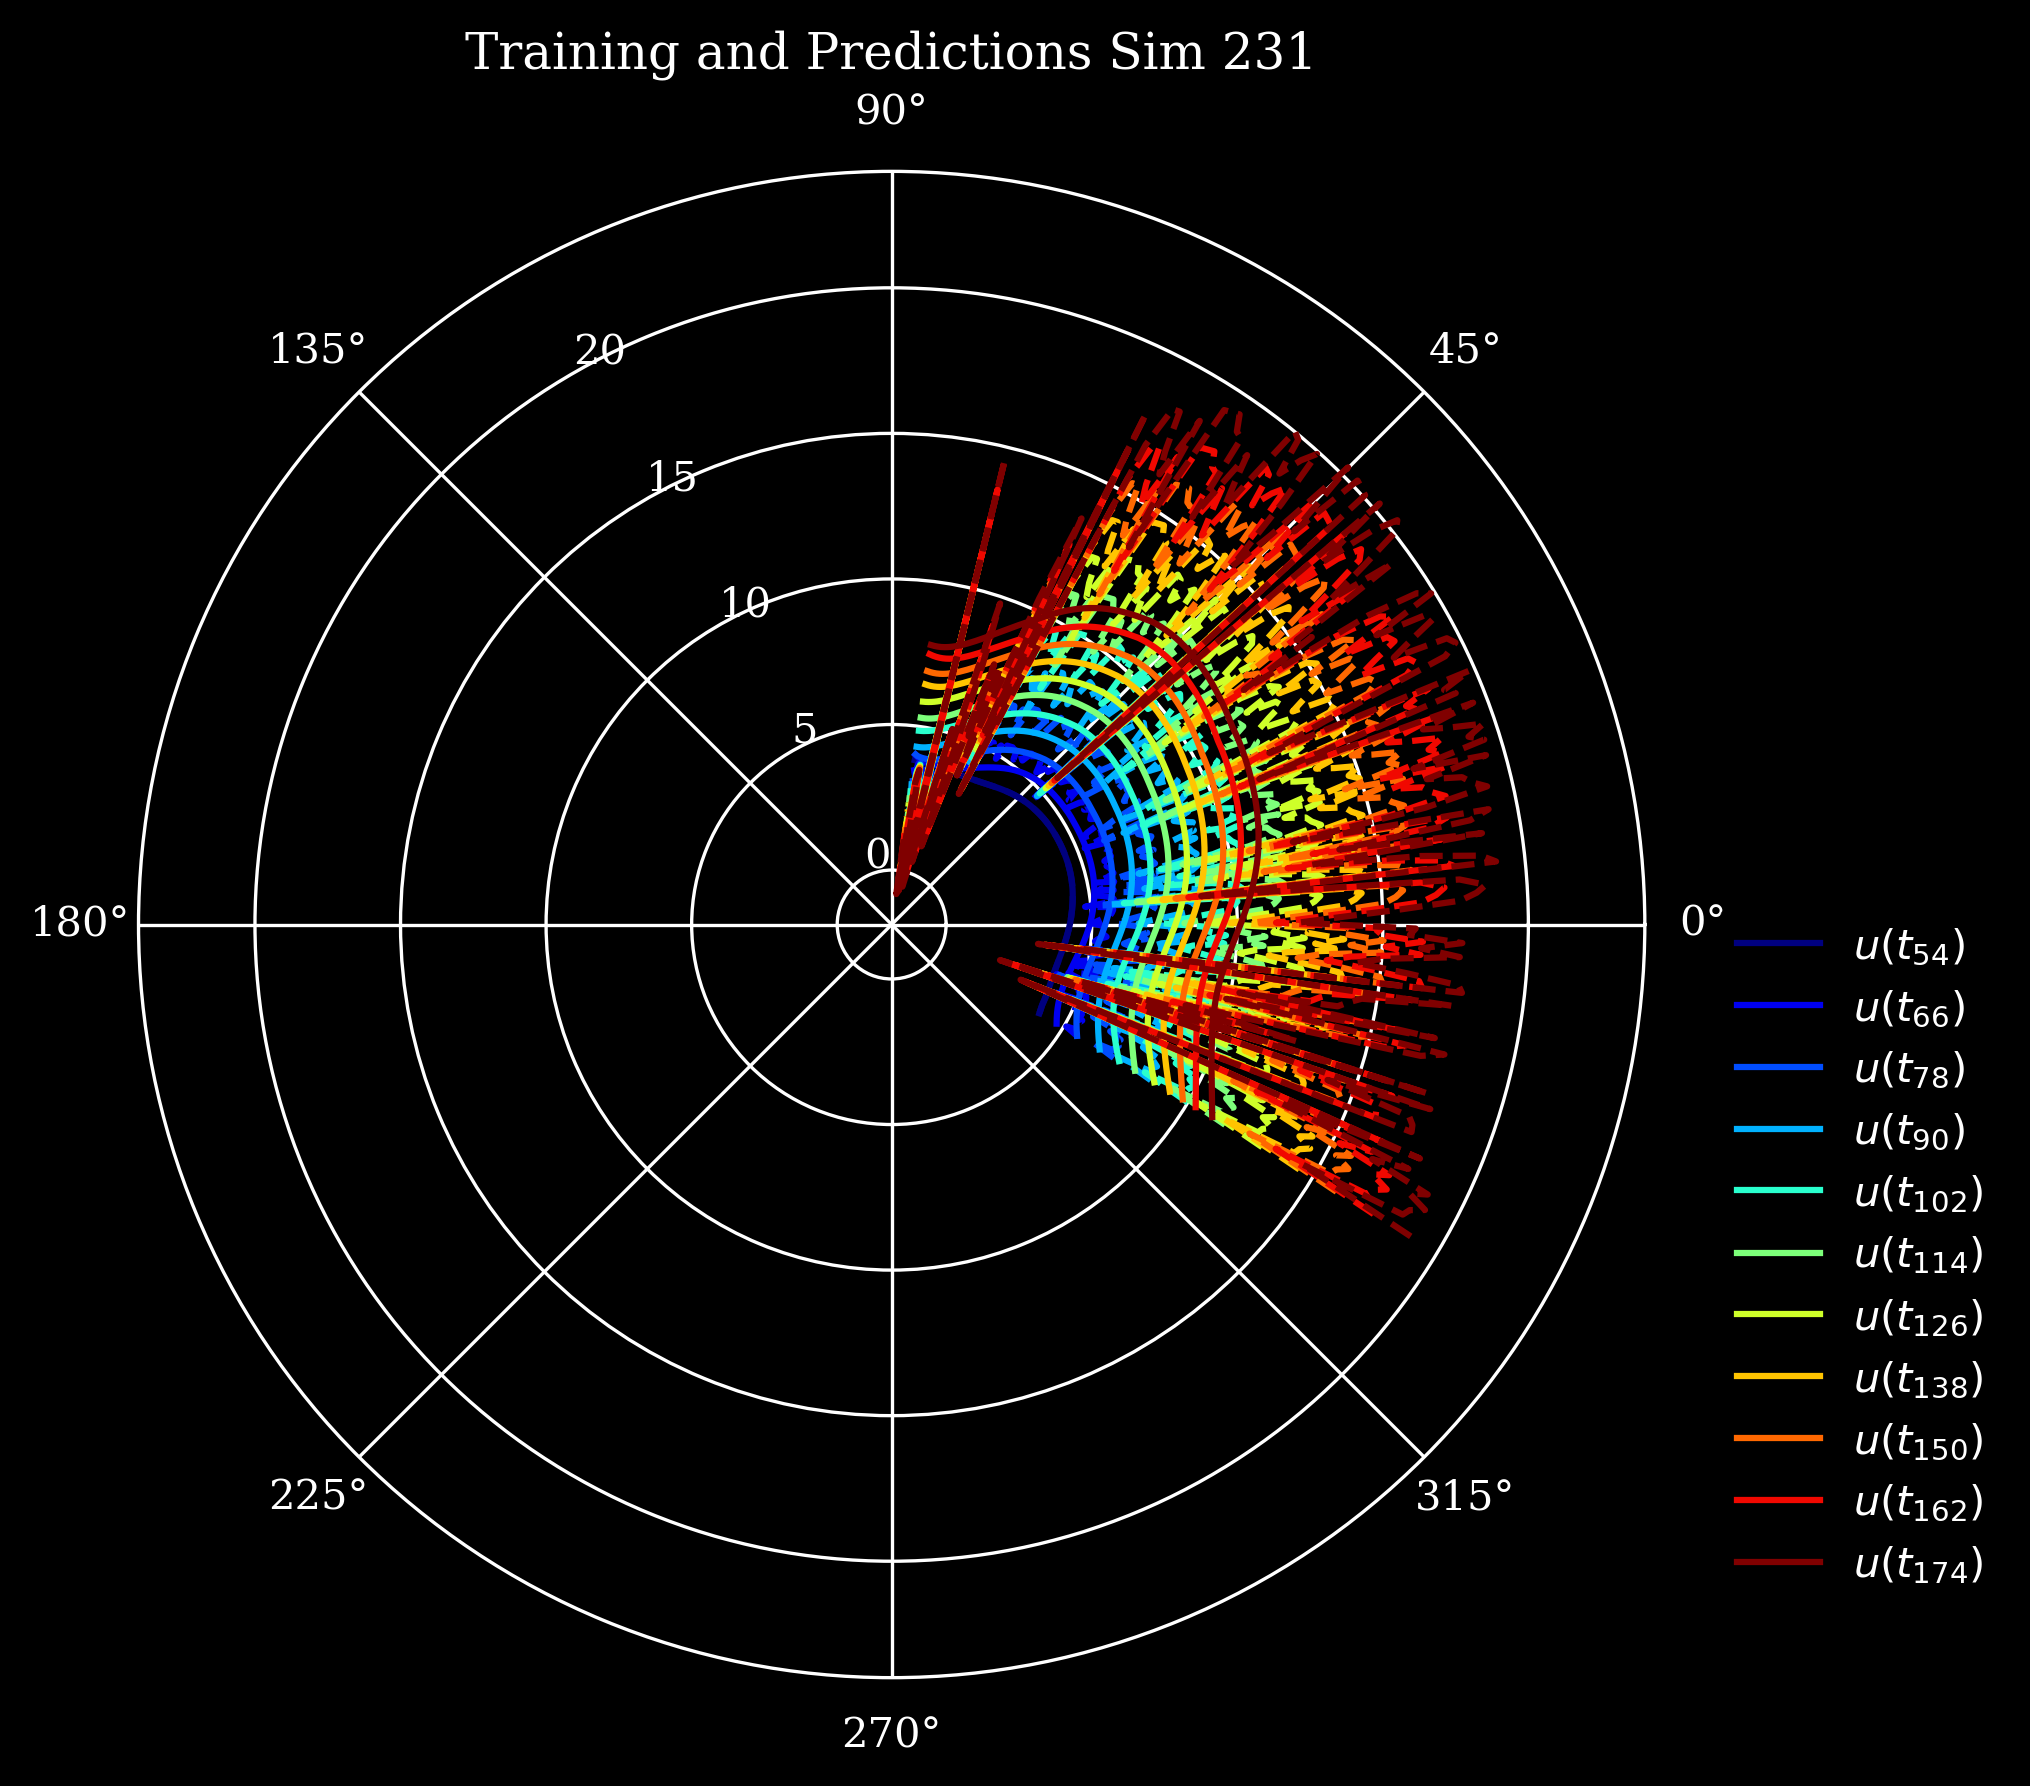

In [117]:
edut.plotTrainPredData1Model(yft_actual[:, :input_dim].cpu().numpy(), pred_y[:, :input_dim].cpu().numpy(), ed_2161, sd_2161, simIdx=186)

clearly we can't expect it to learn just from the IC alone for sure. we need trajectories of data.

In [ ]:
# plot results

#### Try with all sims, it can't hurt!!!

In [ ]:
def getAbsoluteAvgBatchLoss(prediction_tensor, target_tensor):
    """
    both tensors are of dims (n_times, n_batch, 1, len_traj) or (n_times, 1, len_traj)
    """
    
    # swap dimensions of batch and time
    if len(prediction_tensor.shape) > 3:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2, 3))
        target_tensor = torch.permute(target_tensor, (1, 0, 2, 3))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 3)
    else:
        prediction_tensor = torch.permute(prediction_tensor, (1, 0, 2))
        target_tensor = torch.permute(target_tensor, (1, 0, 2))
        # print(prediction_tensor.shape)#testing
        # get torch.abs of difference
        abs_diff = torch.abs(prediction_tensor - target_tensor)

        # sum over trajectory length
        batch_sums = torch.sum(abs_diff, 2)


    # print(batch_sums.shape)  #testing
    
    # get mean of final tensor to get batch and time averaged absolute loss
    batch_loss = torch.mean(batch_sums)
    
    # print(batch_loss)#testing
    
    return batch_loss

In [ ]:
niters = 400
test_freq = 5

In [ ]:
len(sd_train)

In [ ]:
import logging

# stealing this from: 
# https://github.com/rtqichen/torchdiffeq/blob/master/examples/odenet_mnist.py#L250C1-L274C18
def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
        #     logger.info(filepath)

        #     with open(filepath, "r") as f:
        #         logger.info(f.read())

        #     for f in package_files:
        #         logger.info(f)
        #         with open(f, "r") as package_f:
        #             logger.info(package_f.read())

    return logger

In [ ]:
logger = get_logger(logpath=os.path.join(os.getcwd(), "combined_nn_training.log"))

In [ ]:
func = ODEFuncNet(input_dim, param_dim).to(device)
optimizer = optim.Adam(func.parameters(), lr=1e-3)

In [ ]:
logger.info(func)
# logger.info("Number of parameters: {}".format(count_parameters(func)))

**Thoughts**: We should probably take an average over the entire training set i.e. do loss update and every pre-set number of iterations, check loss on all sims in training set integrated from IC, and use that as benchmark.
As more sims are fed in, the overall error over all sims should reduce, use mean absolute error instead of our function (faster). Also, its better to let this run on NERSC.

Meta-learning? i.e. train on one simulation, but also do a second update based on performance on other simulations?

$$\theta^{\ast} = \arg \min_{\theta}\mathbb{E}_{\mathcal{D} \sim p(\mathcal{D})} \mathcal{L}_{\theta}(\mathcal{D})$$

for the meta-learning case, should we simply attempt to include multiple ICs in one training batch, and possibly all remaining ICs for the meta-update? they can be sampled each time along the lines of https://lilianweng.github.io/posts/2018-11-30-meta-learning/train-meta-learner.png

In [ ]:
for sid in sd_train:
    chosen_sim = sid
    y0_train_torch, y_train_torch, y_full_torch, t_train_torch, t_scaled_torch, sim_index = getDataForSim(ed_2161,
                                                                                                          augmented_r,
                                                                                                          sd_2161,
                                                                                                          chosen_sim)
    
    logger.info("Running {} for Sim {}".format(niters, chosen_sim))
    for itr in range(1, niters + 1):
        optimizer.zero_grad()


        batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)

        func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[chosen_sim - 30 - 1].to_numpy()), axis=(0, 1))))

        pred_y = torch.zeros_like(batch_y)

        for i in range(batch_size):
            pred_y[:, i, :, :] = torch.squeeze(odeint(func, batch_y0[[i], :, :], batch_t[i, :]), 1).to(device)

        loss = getLossAllTrainSims(pred_y, batch_y)
        loss.backward()
        optimizer.step()


        if itr % test_freq == 0:
            with torch.no_grad():
                func.set_params(torch.tensor(np.expand_dims(np.float32(cme_params_norm.loc[chosen_sim - 30 - 1].to_numpy()), axis=(0, 1))))
                pred_y_full_series = odeint(func, 
                                            torch.unsqueeze(y0_train_torch, 0), 
                                            t_scaled_torch)

                loss_full_series = getAbsoluteAvgBatchLoss(torch.squeeze(pred_y_full_series, 1),
                                                           y_full_torch)
                logger.info("Iter {:04d} | Total Loss {:.6f} | Sim {:03d} ".format(itr,
                                                                loss_full_series.item(), 
                                                                chosen_sim))

        end = time.time()

In [ ]:
# chosen_sim = np.random.choice(sd_train)
# y0_train_torch,y_train_torch,y_full_torch,t_train_torch,t_scaled_torch, sim_index = getDataForSim(ed_2161,
#                                                                                                   augmented_r,
#                                                                                                   sd_2161,
#                                                                                                   chosen_sim)
# batch_y0, batch_t, batch_y = get_batch(y_train_torch, t_train_torch)                                                                                                     

In [ ]:
# def getParamsTorch(param_series, n_repeats):
#     """
#     param_series is a row from dataframe in pd. Series shape which we convert to torch tensor of suitable dims
#     """
#     return torch.from_numpy(np.float32(np.expand_dims(np.repeat(np.expand_dims(param_series.to_numpy(), axis=0), n_repeats, axis=0), axis=1)))

In [ ]:
# getParamsTorch(cme_params_norm.loc[chosen_sim - 30 - 1], 10).shape

In [5]:
import os
import numpy as np

In [6]:
scratch_dir = os.environ["PSCRATCH"]
trained_models = os.path.join(scratch_dir, "trained_models_1d_edge")

In [7]:
sd_train = np.load(os.path.join(scratch_dir, trained_models, "sd_train.npy"))
sd_test  = np.load(os.path.join(scratch_dir, trained_models, "sd_test.npy"))
sd_calib = np.load(os.path.join(scratch_dir, trained_models, "sd_calib.npy"))

In [8]:
sd_calib

array([ 34,  41,  50,  51,  54,  64,  65,  68,  69,  72,  82,  89,  93,
        99, 105, 110, 118, 119, 122, 126, 129, 146, 152, 153, 160, 162,
       163, 166, 171, 175, 177, 181, 206, 213, 224, 227, 228, 247, 259,
       265, 267, 280, 286, 294, 300, 302, 306, 307, 316, 321, 326, 328])